<a href="https://colab.research.google.com/github/Perfect-Cube/Volkswagon-imobilothon-4.0/blob/main/BatteryCooling_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.0567 - val_loss: 0.8815
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.8160 - val_loss: 0.7001
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6755 - val_loss: 0.6537
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6294 - val_loss: 0.6437
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6377 - val_loss: 0.6383
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6262 - val_loss: 0.6358
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6303 - val_loss: 0.6366
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6210 - val_loss: 0.6373
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6329 - val_loss: 0.6414
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6238 - val_loss: 0.6366
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6280 - val_loss: 0.6415
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6308 - val_l

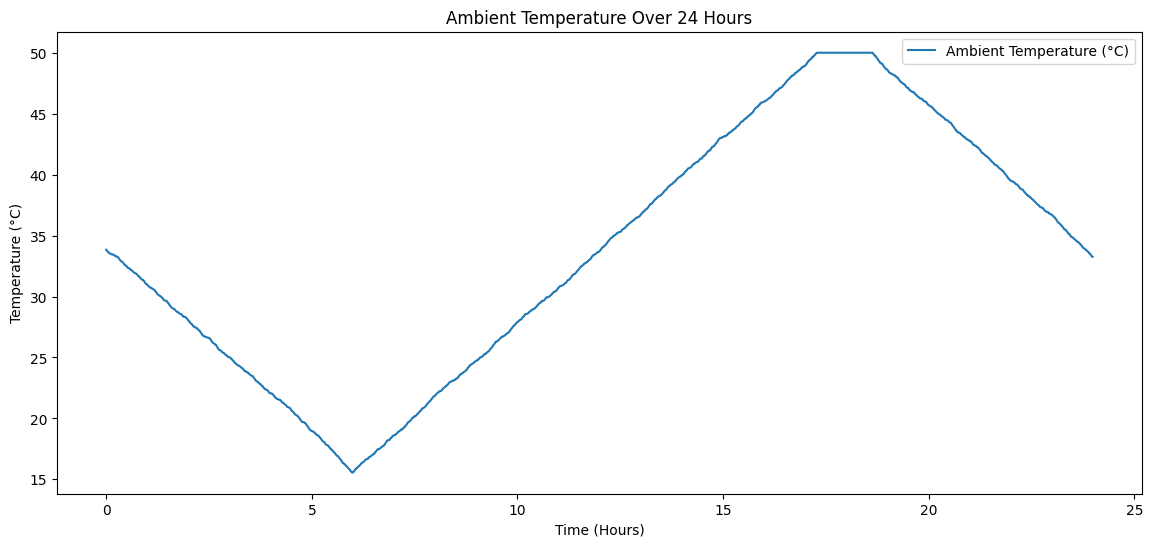

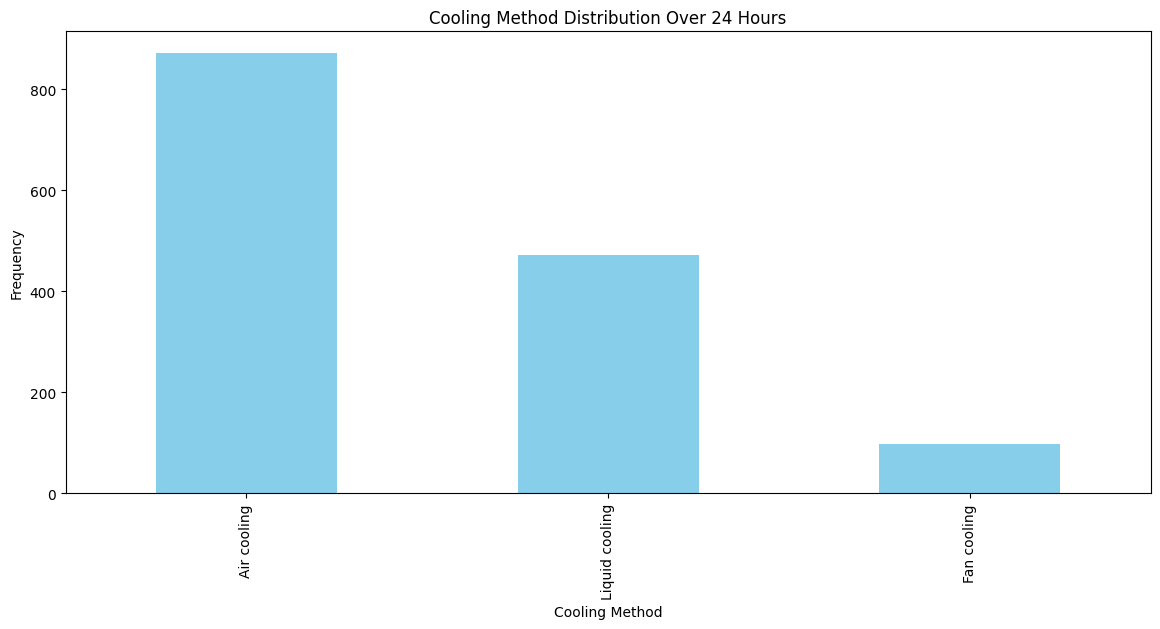

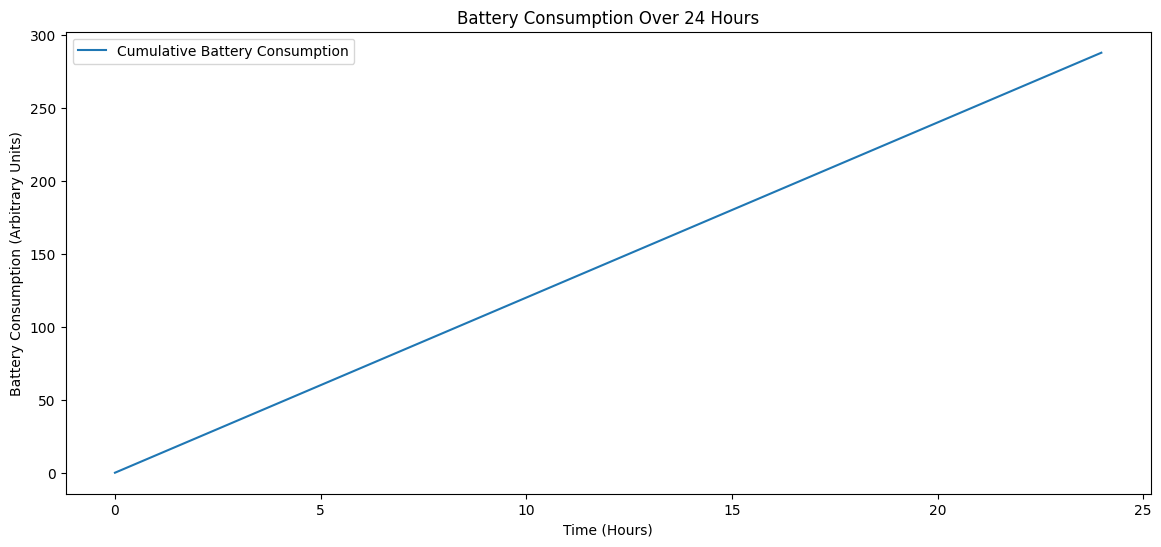

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import random
import matplotlib.pyplot as plt

# Generate a simulated dataset for initial model training
data = pd.DataFrame({
    'route': np.random.choice(['urban', 'highway', 'hilly', 'coastal'], size=5000),
    'ambient_temp': np.random.uniform(10, 50, size=5000),
    'speed': np.random.uniform(0, 120, size=5000),
    'motor_workload': np.random.uniform(0, 1, size=5000),
    'battery_temp': np.random.uniform(20, 80, size=5000)
})

# One-hot encode the 'route' column
data = pd.get_dummies(data, columns=['route'])

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['ambient_temp', 'speed', 'motor_workload', 'battery_temp']])

# VAE Model
latent_dim = 2
inputs = Input(shape=(scaled_features.shape[1],))
h = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_h = Dense(64, activation='relu')
decoder_mean = Dense(scaled_features.shape[1])
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Custom VAE loss layer
class VAELossLayer(Layer):
    def call(self, inputs, **kwargs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        z_mean = inputs[2]
        z_log_var = inputs[3]

        reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.add_loss(vae_loss)
        return x_decoded_mean

# Apply the custom loss layer
outputs = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])
vae = Model(inputs, outputs)

# Compile and train the VAE
vae.compile(optimizer='adam')
vae.fit(scaled_features, scaled_features, epochs=50, batch_size=64, validation_split=0.2)

# Cooling methods
def air_cooling():
    return "Air cooling"

def fan_cooling():
    return "Fan cooling"

def liquid_cooling():
    return "Liquid cooling"

# Cooling selection logic
def select_cooling_method(predicted_temp_increase, ambient_temp, speed, route):
    if predicted_temp_increase > 70 or (ambient_temp > 40 and route in ['hilly', 'urban']):
        return liquid_cooling()
    elif predicted_temp_increase > 50 or (ambient_temp > 30 and speed > 80):
        return fan_cooling()
    else:
        return air_cooling()

# Generate cooling scenario for each input
def generate_cooling_scenario(input_data):
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df, columns=['route'])

    # Ensure all columns from training data are present
    missing_cols = set(data.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0

    # Scale input data
    scaled_input = scaler.transform(input_df[['ambient_temp', 'speed', 'motor_workload', 'battery_temp']])

    # Predict with VAE
    generated_data = vae.predict(scaled_input)
    predicted_temp_increase = generated_data[0, -1]

    # Select cooling method
    cooling_method = select_cooling_method(predicted_temp_increase, input_data['ambient_temp'], input_data['speed'], input_data['route'])
    return cooling_method

# Simulation function for one day
def simulate_one_day():
    time_steps = 24 * 60
    simulation_data = []
    route_types = ['urban', 'highway', 'hilly', 'coastal']

    current_route = random.choice(route_types)
    current_temp = random.uniform(20, 40)

    for minute in range(time_steps):
        if 6 * 60 <= minute < 18 * 60:
            current_temp += random.uniform(0, 0.1)
        else:
            current_temp -= random.uniform(0, 0.1)

        if random.random() < 0.01:
            current_route = random.choice(route_types)

        input_data = {
            'ambient_temp': np.clip(current_temp, 10, 50),
            'speed': random.uniform(20, 100),
            'motor_workload': random.uniform(0.3, 0.7),
            'route': current_route
        }

        cooling_method = generate_cooling_scenario(input_data)
        battery_consumption = 1 if cooling_method == "liquid_cooling" else (0.5 if cooling_method == "fan_cooling" else 0.2)

        input_data.update({
            'time_step': minute,
            'cooling_method': cooling_method,
            'battery_consumption': battery_consumption
        })

        simulation_data.append(input_data)

    simulation_df = pd.DataFrame(simulation_data)
    simulation_df.to_csv('ev_cooling_simulation.csv', index=False)
    print("Simulation data saved to 'ev_cooling_simulation.csv'")

    plot_simulation_results(simulation_df)

# Plotting function
def plot_simulation_results(df):
    time_series = df['time_step'] / 60

    plt.figure(figsize=(14, 6))
    plt.plot(time_series, df['ambient_temp'], label='Ambient Temperature (°C)')
    plt.title("Ambient Temperature Over 24 Hours")
    plt.xlabel("Time (Hours)")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 6))
    df['cooling_method'].value_counts().plot(kind='bar', color='skyblue')
    plt.title("Cooling Method Distribution Over 24 Hours")
    plt.xlabel("Cooling Method")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.plot(time_series, df['battery_consumption'].cumsum(), label='Cumulative Battery Consumption')
    plt.title("Battery Consumption Over 24 Hours")
    plt.xlabel("Time (Hours)")
    plt.ylabel("Battery Consumption (Arbitrary Units)")
    plt.legend()
    plt.show()

# Run the simulation
simulate_one_day()
